In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import random
import gym
from gym import spaces
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import collections
from math import *

In [3]:
class UAV(gym.Env):
    def __init__(self):
        super(UAV, self).__init__()
        # 定义状态空间
        self.observation_space = spaces.Dict({
            'position_x':spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'position_y':spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'position_z':spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'Euler_angles_Roll':spaces.Box(low=-np.pi*2/9, high=np.pi*2/9, shape=(1,), dtype=np.float32),
            'Euler_angles_Pitch':spaces.Box(low=-np.pi*2/9, high=np.pi*2/9, shape=(1,), dtype=np.float32),
            'Euler_angles_Yaw':spaces.Box(low=-np.pi, high=np.pi, shape=(1,), dtype=np.float32),
            'velocity_x':spaces.Box(low=-40, high=40, shape=(1,), dtype=np.float32),
            'velocity_y':spaces.Box(low=-40, high=40, shape=(1,), dtype=np.float32),
            'velocity_z':spaces.Box(low=-40, high=40, shape=(1,), dtype=np.float32),
            'angular_rate_Omega':spaces.Box(low=-1.2, high=1.2, shape=(1,), dtype=np.float32),
            'angular_rate_Beta':spaces.Box(low=-1.2, high=1.2, shape=(1,), dtype=np.float32),
            'angular_rate_gamma':spaces.Box(low=-1.2, high=1.2, shape=(1,), dtype=np.float32),
            'battery_state':spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32),
            'flight_modes':spaces.Discrete(3),
            'relative_position_x':spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'relative_position_y':spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'relative_position_z':spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'relative_Euler_angles_Roll':spaces.Box(low=-np.pi, high=np.pi, shape=(1,), dtype=np.float32),
            'relative_Euler_angles_Pitch':spaces.Box(low=-np.pi, high=np.pi, shape=(1,), dtype=np.float32),
            'relative_Euler_angles_Yaw':spaces.Box(low=-np.pi, high=np.pi, shape=(1,), dtype=np.float32),
            'relative_velocity_x':spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'relative_velocity_y':spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'relative_velocity_z':spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'relative_angular_rate_Omega':spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'relative_angular_rate_Beta':spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'relative_angular_rate_gamma':spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
        })
        # 定义动作空间
        self.action_space = spaces.Dict({
            'rotation_speeds_1':spaces.Box(low=0, high=5000, shape=(1,), dtype=np.float32),
            'rotation_speeds_2':spaces.Box(low=0, high=5000, shape=(1,), dtype=np.float32),
            'rotation_speeds_3':spaces.Box(low=0, high=5000, shape=(1,), dtype=np.float32),
            'rotation_speeds_4':spaces.Box(low=0, high=5000, shape=(1,), dtype=np.float32),
            'Rou_a':spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32),
            'Rou_e':spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32),
            'Rou_r':spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32),
            'Rou_t':spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32),
        })
        self.object_state={
            'object_position_x':100.0,
            'object_position_y':0.0,
            'object_position_z':2.0,
            'odject_Euler_angles_Roll':0.0,
            'odject_Euler_angles_Pitch':0.0,
            'odject_Euler_angles_Yaw':0.0,
            'object_velocity_x':4.0,
            'object_velocity_y':0.0,
            'object_velocity_z':0.0,
        }
        self.done=False
        self.t=0
        self.a_e_r=[0,0,0]
        self.state=[]
        

    
    def reset(self):# 初始化环境状态
        #目标的初始值
        self.t=10
        self.object_state={
            'object_position_x':1.5*self.t*cos(self.t),
            'object_position_y':1.5*self.t*sin(self.t),
            'object_position_z':100+5*self.t,
            'odject_Euler_angles_Roll':0.0,
            'odject_Euler_angles_Pitch':0.0,
            'odject_Euler_angles_Yaw':0.0,
            'object_velocity_x':0.0,
            'object_velocity_y':0.0,
            'object_velocity_z':0.0,
        }
        
        #无人机的初始值
        self.state={
            'position_x':0,
            'position_y':0,
            'position_z':100,
            'Euler_angles_Roll':0.0,
            'Euler_angles_Pitch':0.0,
            'Euler_angles_Yaw':0.0,
            'velocity_x':0.1,
            'velocity_y':0.1,
            'velocity_z':0.1,
            'angular_rate_Omega':0.0,
            'angular_rate_Beta':0.0,
            'angular_rate_gamma':0.0,
            'battery_state':100.0,
            'flight_modes':-1
        }
        self.state['relative_position_x']=self.state['position_x']-self.object_state['object_position_x']
        self.state['relative_position_y']=self.state['position_y']-self.object_state['object_position_y']
        self.state['relative_position_z']=self.state['position_z']-self.object_state['object_position_z']
        self.state['relative_Euler_angles_Roll']=self.state['Euler_angles_Roll']-self.object_state['odject_Euler_angles_Roll']
        self.state['relative_Euler_angles_Pitch']=self.state['Euler_angles_Pitch']-self.object_state['odject_Euler_angles_Pitch']
        self.state['relative_Euler_angles_Yaw']=self.state['Euler_angles_Yaw']-self.object_state['odject_Euler_angles_Yaw']
        self.state['relative_velocity_x']=self.state['velocity_x']-self.object_state['object_velocity_x']
        self.state['relative_velocity_y']=self.state['velocity_y']-self.object_state['object_velocity_y']
        self.state['relative_velocity_z']=self.state['velocity_z']-self.object_state['object_velocity_z']
        self.state['relative_angular_rate_Omega']=self.state['angular_rate_Omega']
        self.state['relative_angular_rate_Beta']=self.state['angular_rate_Beta']
        self.state['relative_angular_rate_gamma']=self.state['angular_rate_gamma']
        self.action_space={
            'rotation_speeds_1':100.0,
            'rotation_speeds_2':100.0,
            'rotation_speeds_3':100.0,
            'rotation_speeds_4':100.0,
            'Rou_a':0,
            'Rou_e':0,
            'Rou_r':0,
            'Rou_t':10
        }
        self.a_e_r=[0,0,0]
        return self.state

    def step(self,action):# 执行一个时间步
        self.done=False
        if sqrt(self.state['velocity_x']**2+self.state['velocity_y']**2+self.state['velocity_z']**2)>=12 and self.state['flight_modes']==-1:
            self.state['flight_modes']=0
        elif sqrt(self.state['velocity_x']**2+self.state['velocity_y']**2+self.state['velocity_z']**2)>=12 and self.state['flight_modes']==0:
            self.state['flight_modes']=1
        elif sqrt(self.state['velocity_x']**2+self.state['velocity_y']**2+self.state['velocity_z']**2)<12 and self.state['flight_modes']==1:
            self.state['flight_modes']=0
        elif sqrt(self.state['velocity_x']**2+self.state['velocity_y']**2+self.state['velocity_z']**2)<12 and self.state['flight_modes']==0:
            self.state['flight_modes']=-1

        d_u=0
        d_v=0
        d_w=0
        d_p=0
        d_q=0
        d_r=0
        d_roll=0
        d_pitch=0
        d_yaw=0

        if self.state['flight_modes']==-1:
            Rou_a_sp=action[0][4]
            Rou_e_sp=action[0][5]
            Rou_r_sp=action[0][6]
            Rou_t=action[0][7]**2
            Rou_MR1=action[0][0]**2
            Rou_MR2=action[0][1]**2
            Rou_MR3=action[0][2]**2
            Rou_MR4=action[0][3]**2
            Rou_a=0
            Rou_e=0
            Rou_r=0
            u=self.state['velocity_x']
            v=self.state['velocity_y']
            w=self.state['velocity_z']
            p=self.state['angular_rate_Omega']
            q=self.state['angular_rate_Beta']
            r=self.state['angular_rate_gamma']
            roll=self.state['Euler_angles_Roll']
            pitch=self.state['Euler_angles_Pitch']
            yaw=self.state['Euler_angles_Yaw']

            V=sqrt(u**2+v**2+w**2)
            q_=0.5*1.225*V**2
            Alpha=atan(w/u)
            Beta=asin(v/V)

            V_0=1
            p_jian=(2.5*p)/(2*V_0)
            q_jian=(0.242*q)/(2*V_0)
            r_jian=(2.5*r)/(2*V_0)

            delta_rou_a=radians(Rou_a-3.0309)
            delta_rou_e=radians(Rou_e+5.6436)
            delta_rou_r=radians(Rou_r)

            Rou_a=radians(Rou_a)
            Rou_e=radians(Rou_e)
            Rou_r=radians(Rou_r)

            T=1.225*0.381**4*0.084*Rou_t
            T_MR1=1.225*0.4064**4*0.0994*Rou_MR1
            T_MR2=1.225*0.4064**4*0.0994*Rou_MR2
            T_MR3=1.225*0.4064**4*0.0994*Rou_MR3
            T_MR4=1.225*0.4064**4*0.0994*Rou_MR4
            Q_MR1=1.225*0.4064**5*0.006338*Rou_MR1
            Q_MR2=1.225*0.4064**5*0.006338*Rou_MR2
            Q_MR3=1.225*0.4064**5*0.006338*Rou_MR3
            Q_MR4=1.225*0.4064**5*0.006338*Rou_MR4

            T_MR=T_MR1+T_MR2+T_MR3+T_MR4

            c_D=0.082+0.272*Alpha+1.81*Alpha**2+10.102*q_jian+(0.132+0.45*Alpha)*delta_rou_e
            c_L=0.461+5.325*Alpha-3.969*Alpha**2+0.521*Rou_e
            c_X=-c_D*cos(Alpha)+c_L*sin(Alpha)
            c_Y=0.0108-0.731*Beta+1.0778*p_jian-0.341*delta_rou_a+0.337*delta_rou_r
            c_Z=-c_D*sin(Alpha)-c_L*cos(Alpha)

            c_l=0.000411-0.0354*Beta-0.242*p_jian+0.0953*r_jian+0.124*delta_rou_a
            c_m=0.095-1.495*Alpha-13.14*q_jian-0.675*delta_rou_e-0.737*Rou_r**2
            c_n=0.00106+0.0759*Beta-0.0823*p_jian-0.0752*r_jian-0.0537*delta_rou_r

            l=q_*c_l*0.6617*2.5
            m=q_*c_m*0.6617*0.242
            n=q_*c_n*0.6617*2.5

            t_x=l+(-0.4*T_MR1+0.4*T_MR2+0.4*T_MR3-0.4*T_MR4)
            t_y=m+(0.353*T_MR1-0.447*T_MR2+0.353*T_MR3-0.447*T_MR4)
            t_z=n+(Q_MR1+Q_MR2-Q_MR3-Q_MR4)

            X=q_*0.6617*c_X
            Y=q_*0.6617*c_Y
            Z=q_*0.6617*c_Z

            F_=0.7316*1.6917-0.1277**2
            F_1=0.1277*(0.7316-1.0664+1.6917)/F_
            F_2=(1.6917*(1.6917-1.0664)+0.1277**2)/F_
            F_3=1.6917/F_
            F_4=0.1277/F_
            F_5=(1.6917-0.7316)/1.0664
            F_6=0.1277/1.0664
            F_7=(0.7316*(0.7316-1.0664)+0.1277**2)/F_
            F_8=0.7316/F_

            d_u=r*v-q*w+1/12.14*(X+T-12.14*9.8*sin(pitch))
            d_v=p*w-r*u+1/12.14+(Y+12.14*9.8*sin(roll)*cos(pitch))
            d_w=q*u-p*v+1/12.14*(Z-T_MR+12.14*9.8*cos(roll)*cos(pitch))
            d_p=F_1*p*q-F_2*q*r+F_3*t_x+F_4*t_z
            d_q=F_5*p*r-F_6*(p**2-r**2)+1/1.0664*t_y
            d_r=F_7*p*q-F_1*q*r+F_4*t_x+F_8*t_z
            d_roll=p+tan(pitch)*(q*sin(roll)+r*cos(roll))
            d_pitch=q*cos(roll)-r*sin(roll)
            d_yaw=(q*sin(roll)+r*cos(roll))/cos(pitch)
            
            values1=[
                    cos(yaw)*cos(pitch),
                    cos(yaw)*sin(pitch)*sin(roll)-sin(yaw)*cos(roll),
                    cos(yaw)*sin(pitch)*cos(roll)+sin(yaw)*sin(roll),
                    sin(yaw)*cos(pitch),
                    sin(yaw)*sin(pitch)*sin(roll)+cos(yaw)*cos(roll),
                    sin(yaw)*sin(pitch)*cos(roll)-cos(yaw)*sin(roll),
                    sin(pitch),
                    -cos(pitch)*sin(roll),
                    -cos(pitch)*cos(roll)
                    ]
            matrix1=np.array(values1).reshape((3,3))
            values2=[u,v,w]
            matrix2=np.array(values2).reshape((3,1))
            values=matrix1 @ matrix2
        elif self.state['flight_modes']==0:
            u=self.state['velocity_x']
            v=self.state['velocity_y']
            w=self.state['velocity_z']
            roll=self.state['Euler_angles_Roll']
            pitch=self.state['Euler_angles_Pitch']
            yaw=self.state['Euler_angles_Yaw']
            d_u=0
            d_v=0
            d_w=0
            d_p=0
            d_q=0
            d_r=0
            d_roll=0
            d_pitch=0
            d_yaw=0
            values1=[
                    cos(yaw)*cos(pitch),
                    cos(yaw)*sin(pitch)*sin(roll)-sin(yaw)*cos(roll),
                    cos(yaw)*sin(pitch)*cos(roll)+sin(yaw)*sin(roll),
                    sin(yaw)*cos(pitch),
                    sin(yaw)*sin(pitch)*sin(roll)+cos(yaw)*cos(roll),
                    sin(yaw)*sin(pitch)*cos(roll)-cos(yaw)*sin(roll),
                    sin(pitch),
                    -cos(pitch)*sin(roll),
                    -cos(pitch)*cos(roll)
                    ]
            matrix1=np.array(values1).reshape((3,3))
            values2=[u,v,w]
            matrix2=np.array(values2).reshape((3,1))
            values=matrix1 @ matrix2
        elif self.state['flight_modes']==1:
            Rou_a_sp=action[0][4]
            Rou_e_sp=action[0][5]
            Rou_r_sp=action[0][6]
            Rou_t=action[0][7]**2
            Rou_MR1=action[0][0]**2
            Rou_MR2=action[0][1]**2
            Rou_MR3=action[0][2]**2
            Rou_MR4=action[0][3]**2
            Rou_a=self.a_e_r[0]
            Rou_e=self.a_e_r[1]
            Rou_r=self.a_e_r[2]
            u=self.state['velocity_x']
            v=self.state['velocity_y']
            w=self.state['velocity_z']
            p=self.state['angular_rate_Omega']
            q=self.state['angular_rate_Beta']
            r=self.state['angular_rate_gamma']
            roll=self.state['Euler_angles_Roll']
            pitch=self.state['Euler_angles_Pitch']
            yaw=self.state['Euler_angles_Yaw']
            x=(-1/0.028*Rou_a+1/0.028*Rou_a_sp)/200
            if x>1:
                x=1
            self.a_e_r[0]+=x*200
            x=(-1/0.028*Rou_e+1/0.028*Rou_e_sp)/200
            if x>1:
                x=1
            self.a_e_r[1]+=x*200
            x=(-1/0.028*Rou_r+1/0.028*Rou_r_sp)/200
            if x>1:
                x=1
            self.a_e_r[2]+=x*200

            V=sqrt(u**2+v**2+w**2)
            q_=0.5*1.225*V**2
            Alpha=atan(w/u)
            Beta=asin(v/V)

            V_0=10
            p_jian=(2.5*p)/(2*V_0)
            q_jian=(0.242*q)/(2*V_0)
            r_jian=(2.5*r)/(2*V_0)

            delta_rou_a=radians(Rou_a-3.0309)
            delta_rou_e=radians(Rou_e+5.6436)
            delta_rou_r=radians(Rou_r)

            Rou_a=radians(Rou_a)
            Rou_e=radians(Rou_e)
            Rou_r=radians(Rou_r)

            T=1.225*0.381**4*0.084*Rou_t
            T_MR1=1.225*0.4064**4*0.0994*Rou_MR1
            T_MR2=1.225*0.4064**4*0.0994*Rou_MR2
            T_MR3=1.225*0.4064**4*0.0994*Rou_MR3
            T_MR4=1.225*0.4064**4*0.0994*Rou_MR4
            Q_MR1=1.225*0.4064**5*0.006338*Rou_MR1
            Q_MR2=1.225*0.4064**5*0.006338*Rou_MR2
            Q_MR3=1.225*0.4064**5*0.006338*Rou_MR3
            Q_MR4=1.225*0.4064**5*0.006338*Rou_MR4

            T_MR=T_MR1+T_MR2+T_MR3+T_MR4

            c_D=0.082+0.272*Alpha+1.81*Alpha**2+10.102*q_jian+(0.132+0.45*Alpha)*delta_rou_e
            c_L=0.461+5.325*Alpha-3.969*Alpha**2+0.521*Rou_e
            c_X=-c_D*cos(Alpha)+c_L*sin(Alpha)
            c_Y=0.0108-0.731*Beta+1.0778*p_jian-0.341*delta_rou_a+0.337*delta_rou_r
            c_Z=-c_D*sin(Alpha)-c_L*cos(Alpha)

            c_l=0.000411-0.0354*Beta-0.242*p_jian+0.0953*r_jian+0.124*delta_rou_a
            c_m=0.095-1.495*Alpha-13.14*q_jian-0.675*delta_rou_e-0.737*Rou_r**2
            c_n=0.00106+0.0759*Beta-0.0823*p_jian-0.0752*r_jian-0.0537*delta_rou_r

            l=q_*c_l*0.6617*2.5
            m=q_*c_m*0.6617*0.242
            n=q_*c_n*0.6617*2.5

            t_x=l+(-0.4*T_MR1+0.4*T_MR2+0.4*T_MR3-0.4*T_MR4)
            t_y=m+(0.353*T_MR1-0.447*T_MR2+0.353*T_MR3-0.447*T_MR4)
            t_z=n+(Q_MR1+Q_MR2-Q_MR3-Q_MR4)

            X=q_*0.6617*c_X
            Y=q_*0.6617*c_Y
            Z=q_*0.6617*c_Z

            F_=0.7316*1.6917-0.1277**2
            F_1=0.1277*(0.7316-1.0664+1.6917)/F_
            F_2=(1.6917*(1.6917-1.0664)+0.1277**2)/F_
            F_3=1.6917/F_
            F_4=0.1277/F_
            F_5=(1.6917-0.7316)/1.0664
            F_6=0.1277/1.0664
            F_7=(0.7316*(0.7316-1.0664)+0.1277**2)/F_
            F_8=0.7316/F_

            d_u=r*v-q*w+1/12.14*(X+T-12.14*9.8*sin(pitch))
            d_v=p*w-r*u+1/12.14+(Y+12.14*9.8*sin(roll)*cos(pitch))
            d_w=q*u-p*v+1/12.14*(Z-T_MR+12.14*9.8*cos(roll)*cos(pitch))
            d_p=F_1*p*q-F_2*q*r+F_3*t_x+F_4*t_z
            d_q=F_5*p*r-F_6*(p**2-r**2)+1/1.0664*t_y
            d_r=F_7*p*q-F_1*q*r+F_4*t_x+F_8*t_z
            d_roll=p+tan(pitch)*(q*sin(roll)+r*cos(roll))
            d_pitch=q*cos(roll)-r*sin(roll)
            d_yaw=(q*sin(roll)+r*cos(roll))/cos(pitch)
            
            values1=[
                    cos(yaw)*cos(pitch),
                    cos(yaw)*sin(pitch)*sin(roll)-sin(yaw)*cos(roll),
                    cos(yaw)*sin(pitch)*cos(roll)+sin(yaw)*sin(roll),
                    sin(yaw)*cos(pitch),
                    sin(yaw)*sin(pitch)*sin(roll)+cos(yaw)*cos(roll),
                    sin(yaw)*sin(pitch)*cos(roll)-cos(yaw)*sin(roll),
                    sin(pitch),
                    -cos(pitch)*sin(roll),
                    -cos(pitch)*cos(roll)
                    ]
            matrix1=np.array(values1).reshape((3,3))
            values2=[u,v,w]
            matrix2=np.array(values2).reshape((3,1))
            values=matrix1 @ matrix2

        
        ''' if d_u>15:
            d_u=15
        if d_v>15:
            d_v=15
        if d_w>15:
            d_w=15
        if d_u<-15:
            d_u=-15
        if d_v<-15:
            d_v=-15
        if d_w<-15:
            d_w=-15'''
        #print(d_u,d_v,d_w,d_p,d_q,d_r,d_roll,d_pitch,d_yaw)
        #print(Y)


        #更新state
        self.state['velocity_x']+=d_u
        self.state['velocity_y']+=d_v
        self.state['velocity_z']+=d_w
        self.state['position_x']+=values[0,0]
        self.state['position_y']+=values[1,0]
        self.state['position_z']+=values[2,0]
        self.state['angular_rate_Omega']+=d_p
        self.state['angular_rate_Beta']+=d_q
        self.state['angular_rate_gamma']+=d_r
        self.state['Euler_angles_Roll']+=d_roll
        self.state['Euler_angles_Pitch']+=d_pitch
        self.state['Euler_angles_Yaw']+=d_yaw
        self.state['Euler_angles_Roll']=self.state['Euler_angles_Roll']%(2*pi)
        self.state['Euler_angles_Pitch']=self.state['Euler_angles_Pitch']%(2*pi)
        self.state['Euler_angles_Yaw']=self.state['Euler_angles_Yaw']%(2*pi)
        self.state['angular_rate_Omega']=self.state['angular_rate_Omega']
        self.state['angular_rate_Beta']=self.state['angular_rate_Beta']
        self.state['angular_rate_gamma']=self.state['angular_rate_gamma']
        self.state['relative_position_x']=self.state['position_x']-self.object_state['object_position_x']
        self.state['relative_position_y']=self.state['position_y']-self.object_state['object_position_y']
        self.state['relative_position_z']=self.state['position_z']-self.object_state['object_position_z']
        self.state['relative_Euler_angles_Roll']=self.state['Euler_angles_Roll']-self.object_state['odject_Euler_angles_Roll']
        self.state['relative_Euler_angles_Pitch']=self.state['Euler_angles_Pitch']-self.object_state['odject_Euler_angles_Pitch']
        self.state['relative_Euler_angles_Yaw']=self.state['Euler_angles_Yaw']-self.object_state['odject_Euler_angles_Yaw']
        self.state['relative_velocity_x']=self.state['velocity_x']-self.object_state['object_velocity_x']
        self.state['relative_velocity_y']=self.state['velocity_y']-self.object_state['object_velocity_y']
        self.state['relative_velocity_z']=self.state['velocity_z']-self.object_state['object_velocity_z']
        self.state['relative_angular_rate_Omega']=self.state['angular_rate_Omega']
        self.state['relative_angular_rate_Beta']=self.state['angular_rate_Beta']
        self.state['relative_angular_rate_gamma']=self.state['angular_rate_gamma']
        self.state['battery_state']-=0.1

        #更新object
        self.object_state['object_position_x']=0.15*self.t*cos(self.t)
        self.object_state['object_position_y']=0.15*self.t*sin(self.t)
        self.object_state['object_position_z']=0.5*self.t
        self.t+=1

        self.done=self._check_done()
        if self.done==False:
            reward=self._calculate_reward()
        else:
            reward=0
        #print(reward)
        return [value for key, value in self.state.items()],reward,self.done,{}

    def _calculate_reward(self):#计算奖励
        rho_0=1.0
        rho_1=50.0
        rho=sqrt(self.state['relative_position_x']**2+self.state['relative_position_y']**2+self.state['relative_position_z']**2)
        #计算r_dis
        if rho>rho_1:
            r_dis=-rho
        else:
            r_dis=-(rho-rho_0)
        #计算r_ang
        if rho>rho_1:
            r_ang=-sqrt(self.state['relative_Euler_angles_Yaw']**2)
        else:
            r_ang=-sqrt(self.state['relative_Euler_angles_Roll']**2+self.state['relative_Euler_angles_Pitch']**2+self.state['relative_Euler_angles_Yaw']**2)
        #计算r_vel
        if rho>rho_1:
            r_vel=-sqrt((self.state['velocity_x']-40.0)**2+(self.state['velocity_y']-40.0)**2+(self.state['velocity_z']-40.0)**2)
        else:
            r_vel=-sqrt(self.state['relative_velocity_x']**2+self.state['relative_velocity_y']**2+self.state['relative_velocity_z']**2)
        #计算r_rat
        if rho>rho_0:
            r_rat=0
        else:
            r_rat=-sqrt(self.state['relative_angular_rate_Omega']**2+self.state['relative_angular_rate_Beta']**2+self.state['relative_angular_rate_gamma']**2)
        #计算r_mod
        velocity=sqrt(self.state['velocity_x']**2+self.state['velocity_y']**2+self.state['velocity_z']**2)
        if velocity>12 and self.state['flight_modes']==1:
            r_mod=10
        elif velocity>12 and self.state['flight_modes']==-1:
            r_mod=-15
        elif velocity<8 and self.state['flight_modes']==-1:
            r_mod=10
        elif velocity<8 and self.state['flight_modes']==1:
            r_mod=-15
        else:
            r_mod=0
        #加上权重,得r_total
        r_total=r_dis+0.1*r_vel+r_ang+r_rat+0.1*r_mod
        return r_total
    
    def _check_done(self):
        if self.state['position_z']<0 or self.state['battery_state']<=0 or self.state['position_z']>1000 or abs(self.state['position_y'])>2000:
            return True
        else:
            return False




In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) 

    def add(self, state, action, reward, next_state, done): 
        self.buffer.append((state, action, reward, next_state, done)) 

    def sample(self, batch_size): 
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done 

    def size(self): 
        return len(self.buffer)

In [5]:
class PolicyNet(torch.nn.Module):#建立五层隐藏层的策略网络
    def __init__(self, state_dim, hidden_dim1,hidden_dim2,hidden_dim3,hidden_dim4,hidden_dim5,action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim1)
        self.fc2 = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = torch.nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = torch.nn.Linear(hidden_dim3, hidden_dim4)
        self.fc5 = torch.nn.Linear(hidden_dim4, hidden_dim5)
        self.fc6 = torch.nn.Linear(hidden_dim5, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        lower_bounds = torch.tensor([bound[0] for bound in self.action_bound.values()], device=device)
        upper_bounds = torch.tensor([bound[1] for bound in self.action_bound.values()], device=device)
        fc6_output = self.fc6(x)
        tanh_output = torch.tanh(fc6_output)
        scaled_output = lower_bounds + (upper_bounds - lower_bounds) * (tanh_output + 1) / 2
        return scaled_output


class QValueNet(torch.nn.Module):#建立五层隐藏层的Q网络
    def __init__(self, state_dim, hidden_dim1,hidden_dim2,hidden_dim3,hidden_dim4,hidden_dim5, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim1)
        self.fc2 = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = torch.nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = torch.nn.Linear(hidden_dim3, hidden_dim4)
        self.fc5 = torch.nn.Linear(hidden_dim4, hidden_dim5)
        self.fc_out = torch.nn.Linear(hidden_dim5, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1) # 拼接状态和动作
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return self.fc_out(x)

In [6]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim1,hidden_dim2,hidden_dim3,hidden_dim4,hidden_dim5, action_dim, action_bound, sigma, actor_lr, critic_lr, tau_critic,tau_actor, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim1,hidden_dim2,hidden_dim3,hidden_dim4,hidden_dim5, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim1,hidden_dim2,hidden_dim3,hidden_dim4,hidden_dim5, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim1,hidden_dim2,hidden_dim3,hidden_dim4,hidden_dim5, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim1,hidden_dim2,hidden_dim3,hidden_dim4,hidden_dim5, action_dim).to(device)
        # 初始化目标价值网络并设置和价值网络相同的参数
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并设置和策略相同的参数
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau_critic = tau_critic 
        self.tau_actor = tau_actor
        self.action_dim = action_dim
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state)
        # 给动作添加噪声，增加探索
        
        noise=torch.tensor(self.sigma * np.random.randn(self.action_dim)).to(self.device)
        action = action + noise
        return action

    def soft_update_critic(self, net, target_net):#critic网络的软更新
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau_critic) + param.data * self.tau_critic)
    
    def soft_update_actor(self, net, target_net):#actor网络的软更新
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau_actor) + param.data * self.tau_actor)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update_critic(self.critic, self.target_critic)  # 软更新价值网络
        self.soft_update_actor(self.actor, self.target_actor)  # 软更新策略网络

In [7]:
def train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    state_list=[]
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                state = [value for key, value in env.reset().items()]
                done = False
                state_list_list=[]
                while not done:
                    action = agent.take_action(state).tolist()
                    #print(action)
                    next_state, reward, done, _ = env.step(action)
                    #print('\n',state,'\n',next_state)
                    replay_buffer.add(state, action, reward, next_state, done)
                    if i_episode==int(num_episodes/10)-1:
                        state_list_list.append(state[:3])
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                        agent.update(transition_dict)
                #print(episode_return)
                if i_episode==int(num_episodes/10)-1:
                    state_list.append(state_list_list)
                return_list.append(episode_return)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list,state_list

In [8]:
actor_lr = 3e-4
critic_lr = 3e-3
num_episodes = 2000
#隐藏层
hidden_dim1 = 128
hidden_dim2 = 256
hidden_dim3 = 512
hidden_dim4 = 128
hidden_dim5 = 64
gamma = 0.9
# 软更新参数
tau_critic=0.001
tau_actor = 0.002 

buffer_size = 500
minimal_size = 1000
batch_size = 64
sigma = 0.01  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
env_name = 'UAV'
env = UAV()
#random.seed(0)
#np.random.seed(0)
#env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = 26
action_dim = 8
action_bound = {
    'rotation_speeds_1':(10,200),
    'rotation_speeds_2':(10,200),
    'rotation_speeds_3':(10,200),
    'rotation_speeds_4':(10,200),
    'a':(0,25),
    'e':(0,25),
    'r':(0,22),
    't':(10,200)
}
agent = DDPG(state_dim, hidden_dim1,hidden_dim2,hidden_dim3,hidden_dim4,hidden_dim5, action_dim, action_bound, sigma, actor_lr, critic_lr, tau_critic,tau_actor, gamma, device)
  
return_list,state_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)
#print(state_list)

Iteration 9: 100%|██████████| 200/200 [00:00<00:00, 310.41it/s, episode=2000, return=-889.109]


In [9]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

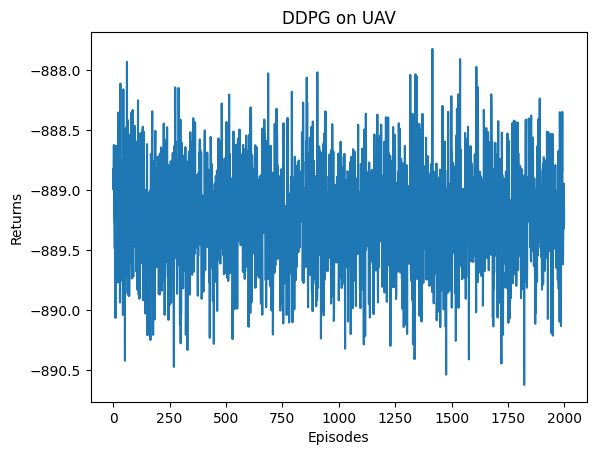

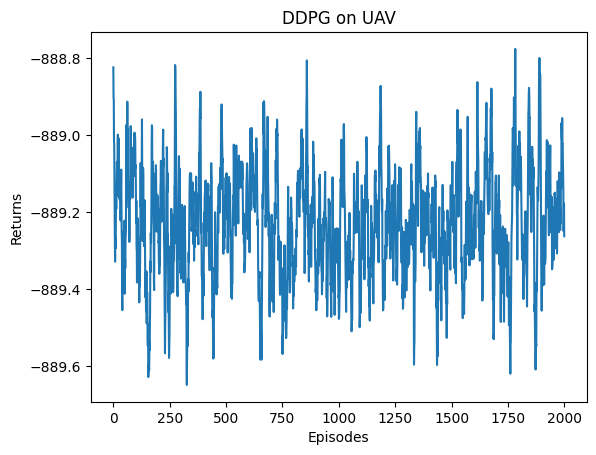

In [10]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

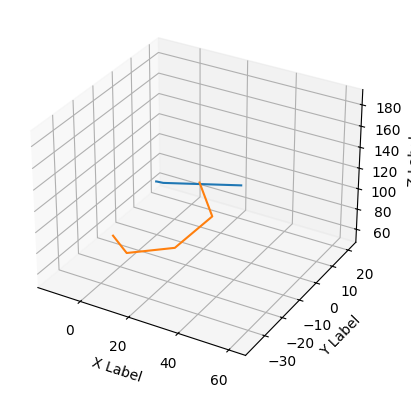

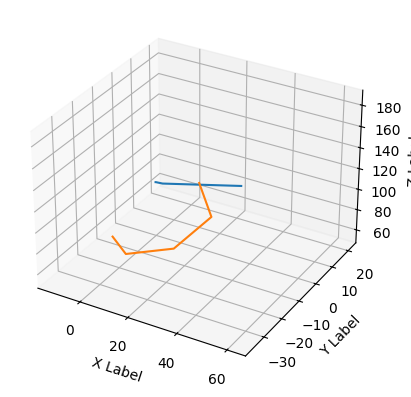

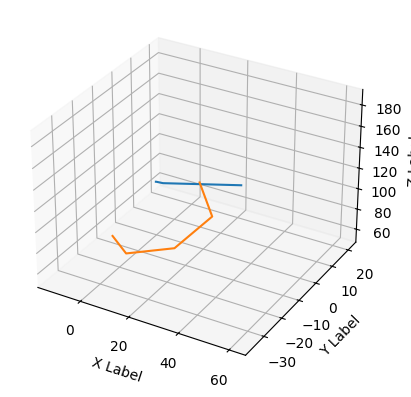

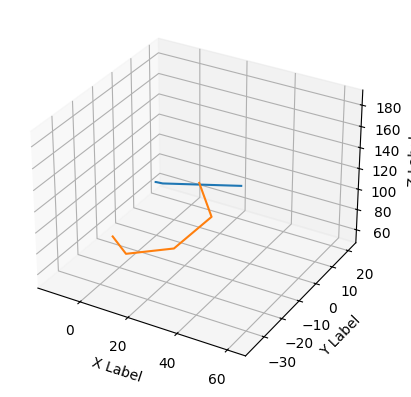

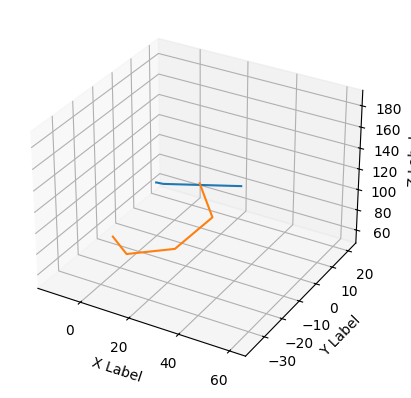

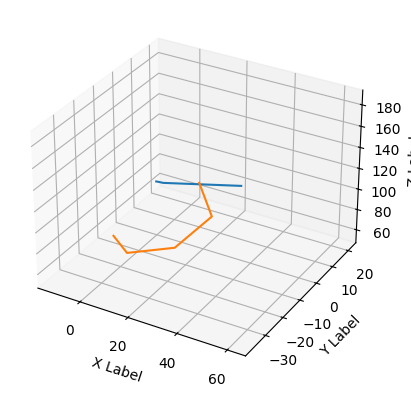

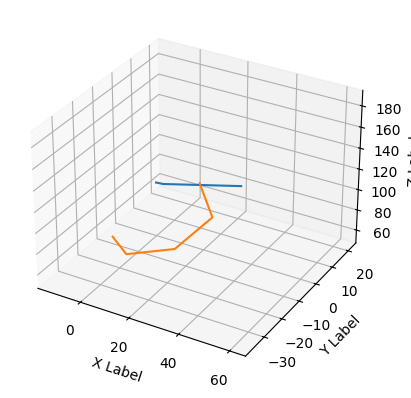

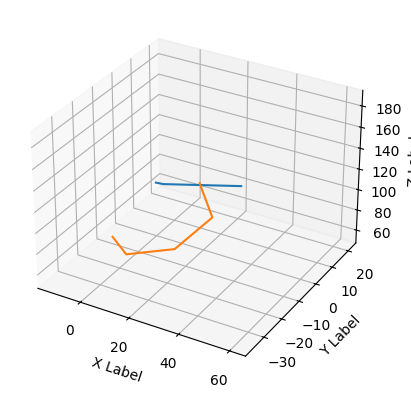

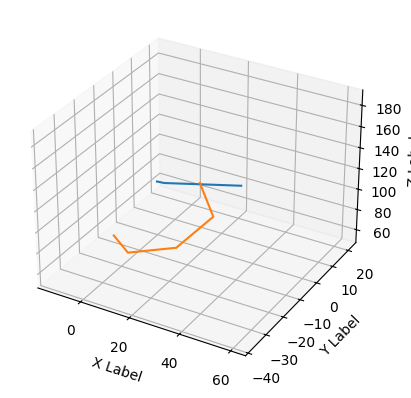

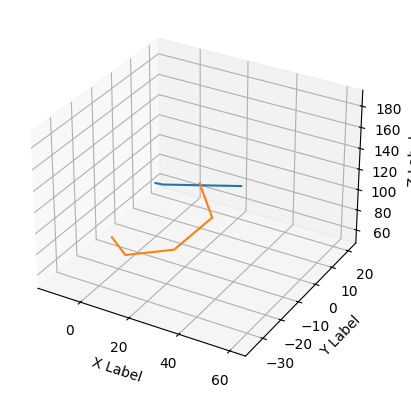

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 创建数据
for i in range(len(state_list)):
    x=[]
    y=[]
    z=[]
    for j in range(len(state_list[i])):
        x.append(state_list[i][j][0])
        y.append(state_list[i][j][1])
        z.append(state_list[i][j][2])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x, y, z)

    ox=[]
    oy=[]
    oz=[]
    for j in range(len(state_list[i])):
        ox.append(1.5*(j+10)*cos(j+10))
        oy.append(1.5*(j+10)*sin(j+10))
        oz.append(5*(j+10))
    ax.plot(ox,oy,oz)


    # 设置标签
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()
